In [4]:
%pip install tensorflow==2.12

  Using cached tensorflow-2.12.0-cp310-cp310-win_amd64.whl.metadata (2.5 kB)
  Using cached tensorflow_intel-2.12.0-cp310-cp310-win_amd64.whl.metadata (4.1 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.12.23-py2.py3-none-any.whl.metadata (876 bytes)
  Using cached gast-0.4.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached h5py-3.12.1-cp310-cp310-win_amd64.whl.metadata (2.5 kB)
  Using cached jax-0.4.38-py3-none-any.whl.metadata (22 kB)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-4.25.5-cp310-abi3-win_amd64.whl.metadata (541 bytes)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached wrapt-1.14.1-cp310-cp310-win_amd64.whl.metadata (6.7 kB)
  Usi


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\marek\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


   ------------------ --------------------- 123.6/272.8 MB 1.0 MB/s eta 0:02:29
   ------------------ --------------------- 123.7/272.8 MB 1.0 MB/s eta 0:02:29
   ------------------ --------------------- 123.7/272.8 MB 1.0 MB/s eta 0:02:28
   ------------------ --------------------- 123.8/272.8 MB 1.0 MB/s eta 0:02:28
   ------------------ --------------------- 123.8/272.8 MB 1.0 MB/s eta 0:02:27
   ------------------ --------------------- 123.9/272.8 MB 1.0 MB/s eta 0:02:27
   ------------------ --------------------- 123.9/272.8 MB 1.0 MB/s eta 0:02:27
   ------------------ --------------------- 123.9/272.8 MB 1.0 MB/s eta 0:02:26
   ------------------ --------------------- 124.0/272.8 MB 1.0 MB/s eta 0:02:26
   ------------------ --------------------- 124.0/272.8 MB 1.0 MB/s eta 0:02:26
   ------------------ --------------------- 124.0/272.8 MB 1.0 MB/s eta 0:02:26
   ------------------ --------------------- 124.1/272.8 MB 1.0 MB/s eta 0:02:25
   ------------------ ------------------

In [5]:
import tensorflow as tf
import numpy as np
import os
import time

In [6]:
tf.__version__

'2.12.0'

### SOURCE TEXT LOADING
- loading .txt
- printing the beginning, number of characters, number of unique characters
    

In [10]:
with open("ring.txt", "r", encoding="utf-8") as f:
    source = f.read()
print(type(source))
print(source[:200])


<class 'str'>
THE  FELLOWSHIP 
OF  THE  RING 


BEING  THE  FIRST  PART 
OF 

The  Lord  of  the  Rings 


BOOK  ONE 


Chapter  I 


A  LONG-EXPECTED  PARTY 


When  Mr.  Bilbo  Baggins  of  Bag  End  announced  t


In [11]:
print (f"{len(source)} characters")

1145534 characters


In [12]:
vocab = sorted(set(source))
print (f"{len(vocab)} unique characters")

88 unique characters


In [13]:
# unique characters to indices mapping
char2index = {u: i for i, u in enumerate(vocab)}
index2char = np.array(vocab)

text_as_int = np.array([char2index[c] for c in source])

print(text_as_int)

[45 33 30 ...  1  0  0]


In [14]:
print (f"{repr(source[:13])} -- characters mapped to int -- > {text_as_int[:13]}")

'THE  FELLOWSH' -- characters mapped to int -- > [45 33 30  1  1 31 30 37 37 40 48 44 33]


### DATASET PREPROCESSING
- character to index mapping and converting text to numerical representation
- defining max input sequence length
- creating TensorFlow Dataset from the source
- creating batches from dataset
- input-target split function (:-1 is input, and last element is expected value)
- applying input-target split function to each batch

In [15]:
seq_length = 100
examples_per_epoch = len(source)//(seq_length+1)

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  print(index2char[i.numpy()])


T
H
E
 
 


In [16]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
  print(repr(''.join(index2char[item.numpy()])))

'THE  FELLOWSHIP \nOF  THE  RING \n\n\nBEING  THE  FIRST  PART \nOF \n\nThe  Lord  of  the  Rings \n\n\nBOOK  ON'
'E \n\n\nChapter  I \n\n\nA  LONG-EXPECTED  PARTY \n\n\nWhen  Mr.  Bilbo  Baggins  of  Bag  End  announced  tha'
't  he \nwould  shortly  be  celebrating  his  eleventy-first  birthday  with \na  party  of  special  m'
'agnificence,  there  was  much  talk  and \nexcitement  in  Hobbiton. \n\nBilbo  was  very  rich  and  v'
'ery  peculiar,  and  had  been  the \nwonder  of  the  Shire  for  sixty  years,  ever  since  his  re'


In [17]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

### PARAMETERS
- training parameters & data shuffling
- model hyperparameters

In [18]:
BATCH_SIZE = 512
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<_BatchDataset element_spec=(TensorSpec(shape=(512, 100), dtype=tf.int32, name=None), TensorSpec(shape=(512, 100), dtype=tf.int32, name=None))>

In [19]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 300 #256

# Number of RNN units
rnn_units1 = 1024
rnn_units2 = 1024
rnn_units=[rnn_units1, rnn_units2]
print(vocab_size)

88


### BUILDING MODEL
- GRU, LSTM, RNN, with Conv1

In [14]:
# # ORIGINAL GRU
# def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
#   model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim,
#                               batch_input_shape=[batch_size, None]),
#     tf.keras.layers.GRU(rnn_units1,
#                         return_sequences=True,
#                         stateful=True,
#                         recurrent_initializer='glorot_uniform'),
#     tf.keras.layers.GRU(rnn_units2,
#                         return_sequences=True,
#                         stateful=True,
#                         recurrent_initializer='glorot_uniform'),
#     tf.keras.layers.Dense(vocab_size)
#   ])
#   return model

In [20]:
# LSTM
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.LSTM(rnn_units1,
                             return_sequences=True,
                             stateful=True,
                             recurrent_initializer='glorot_uniform'),
        tf.keras.layers.LSTM(rnn_units2,
                             return_sequences=True,
                             stateful=True,
                             recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [ ]:
# # RNN
# def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
#     model = tf.keras.Sequential([
#         tf.keras.layers.Embedding(vocab_size, embedding_dim,
#                                   batch_input_shape=[batch_size, None]),
#         tf.keras.layers.SimpleRNN(rnn_units1,
#                                   return_sequences=True,
#                                   stateful=True,
#                                   recurrent_initializer='glorot_uniform'),
#         tf.keras.layers.SimpleRNN(rnn_units2,
#                                   return_sequences=True,
#                                   stateful=True,
#                                   recurrent_initializer='glorot_uniform'),
#         tf.keras.layers.Dense(vocab_size)
#     ])
#     return model


In [ ]:
# # dodanie Conv1
# def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
#     model = tf.keras.Sequential([
#         tf.keras.layers.Embedding(vocab_size, embedding_dim,
#                                   batch_input_shape=[batch_size, None]),
#         tf.keras.layers.Conv1D(filters=128,
#                                kernel_size=5,
#                                activation='relu',
#                                padding='same'),
#         tf.keras.layers.GRU(rnn_units1,
#                             return_sequences=True,
#                             stateful=True,
#                             recurrent_initializer='glorot_uniform'),
#         tf.keras.layers.GRU(rnn_units2,
#                             return_sequences=True,
#                             stateful=True,
#                             recurrent_initializer='glorot_uniform'),
#         tf.keras.layers.Dense(vocab_size)
#     ])
#     return model


In [21]:
model = build_model(
  vocab_size = vocab_size,
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (512, None, 300)          26400     
                                                                 
 lstm (LSTM)                 (512, None, 1024)         5427200   
                                                                 
 lstm_1 (LSTM)               (512, None, 1024)         8392704   
                                                                 
 dense (Dense)               (512, None, 88)           90200     
                                                                 
Total params: 13,936,504
Trainable params: 13,936,504
Non-trainable params: 0
_________________________________________________________________


### MODEL TRAINING
- optimizer & loss function declaration
- compilation
- epochs number
- launching the training

In [23]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [24]:
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [25]:
checkpoint_dir = './checkpoints_RNN'        # TODO: remember to choose proper directory
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [26]:
EPOCHS=20

In [27]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
22/22 [==============================] - 916s 41s/step - loss: 3.2244 - accuracy: 0.2674
Epoch 2/20
22/22 [==============================] - 783s 35s/step - loss: 2.8596 - accuracy: 0.3008
Epoch 3/20
22/22 [==============================] - 830s 38s/step - loss: 2.5978 - accuracy: 0.3319
Epoch 4/20
22/22 [==============================] - 830s 38s/step - loss: 2.3661 - accuracy: 0.3677
Epoch 5/20
22/22 [==============================] - 828s 38s/step - loss: 2.1913 - accuracy: 0.4052
Epoch 6/20
22/22 [==============================] - 895s 41s/step - loss: 2.0120 - accuracy: 0.4362
Epoch 7/20
22/22 [==============================] - 1003s 46s/step - loss: 1.9109 - accuracy: 0.4585
Epoch 8/20
22/22 [==============================] - 982s 44s/step - loss: 1.8284 - accuracy: 0.4801
Epoch 9/20
22/22 [==============================] - 904s 41s/step - loss: 1.7413 - accuracy: 0.5033
Epoch 10/20
22/22 [==============================] - 965s 44s/step - loss: 1.6646 - accuracy: 0.522

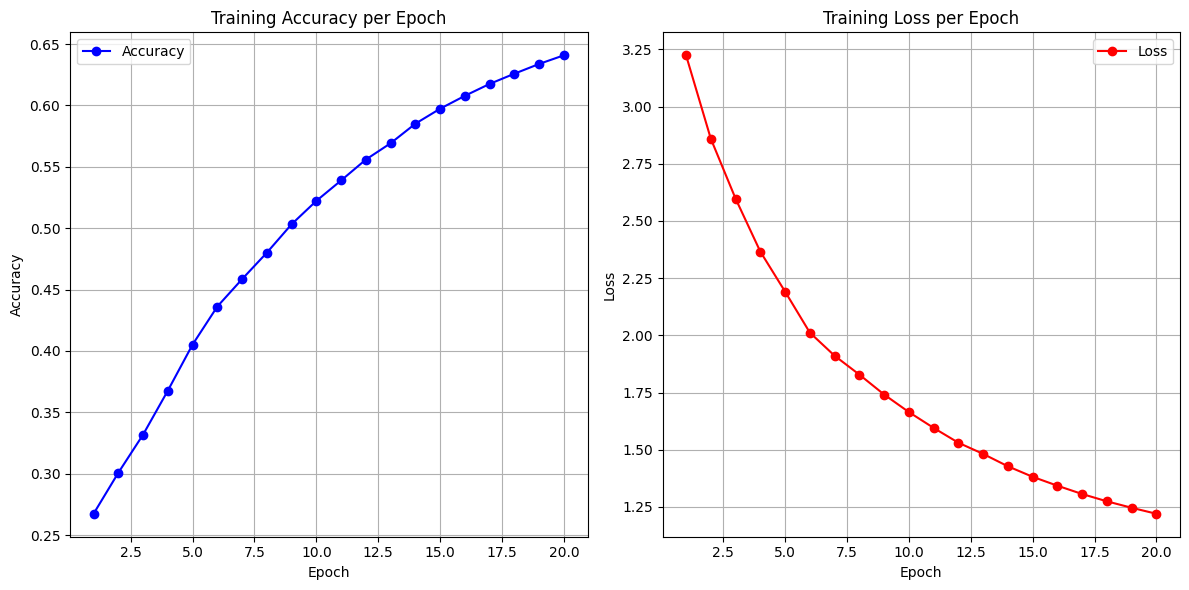

In [29]:
import matplotlib.pyplot as plt

# Pobranie wartości strat i dokładności z historii
loss = history.history['loss']
accuracy = history.history['accuracy']
epochs = range(1, len(loss) + 1)

# Wykres strat i dokładności
plt.figure(figsize=(12, 6))

# Wykres strat
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, marker='o', label='Accuracy', color='blue')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Wykres dokładności
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, marker='o', label='Loss', color='red')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### RESULTS
- bulding the model and applying saved weights
- text generation function
- generate text based on the provided beginning

In [30]:
latest_check= tf.train.latest_checkpoint(checkpoint_dir)

In [31]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(latest_check)

model.build(tf.TensorShape([1, None]))

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 300)            26400     
                                                                 
 lstm_2 (LSTM)               (1, None, 1024)           5427200   
                                                                 
 lstm_3 (LSTM)               (1, None, 1024)           8392704   
                                                                 
 dense_1 (Dense)             (1, None, 88)             90200     
                                                                 
Total params: 13,936,504
Trainable params: 13,936,504
Non-trainable params: 0
_________________________________________________________________


In [33]:
def generate_text(model, start_string):

  num_generate = 1000
  input_eval = [char2index[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)
  text_generated = []
  scaling = 0.5

  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      predictions = tf.squeeze(predictions, 0)
      predictions = predictions / scaling
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      input_eval = tf.expand_dims([predicted_id], 0)
      text_generated.append(index2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [35]:
print(generate_text(model, start_string=u"Bilbo had the Ring "))

Bilbo had the Ring  to  go  some  of  the  trees.  A  strange  they  were  not  in  the  sort  of  the  hill  and  the  same  to  the  world  of  the  Ring,  and  the  long  of  the  Shire  that  had  been  two  way  right  in  the  land  the  darkness  and  the  land  that  can  the  Ring  and  Sam.  The  other  stood  be  the  fall  and  a  stream  and  rider  was  living  and  she  shall  be  a  great  such  of  the  stream  of  the  windows  were  still  the  path  of  the  West  of  the  Sun,  and  then  he  was  in  the  west  of  the  Gater,  and  the  trees  and  the  very  side  the  hills  of  the  Withow  the  great.  Suddenly  it  was  a  think  of  where  they  could  not  to  see  the  start  of  the  trees  and  the  grey  and  the  look  of  the  Ring  and  the  darkness  of  the  path  and  all  the  feather  sige  of  the  hills  again  the  hill  was  disched  with  a  shadow  of  the  Shire,  and  the  companion  shall  be  said  in  the  hills.  The  wind  the  tre

In [36]:
def calculate_cross_entropy_loss(model, test_sequences):
    total_loss = 0
    total_steps = 0

    for sequence in test_sequences:
        input_seq = sequence[:-1]
        target_seq = sequence[1:]

        input_seq = tf.expand_dims(input_seq, 0)

        predictions = model(input_seq)

        loss = tf.keras.losses.sparse_categorical_crossentropy(target_seq, predictions[0], from_logits=True)

        total_loss += tf.reduce_sum(loss).numpy()
        total_steps += len(target_seq)

    avg_loss = total_loss / total_steps
    return avg_loss

In [37]:
# tutaj można załadować inną część tolkiena albo hobbita
first_10_sequences = list(sequences.take(2))

In [38]:
avg_loss = calculate_cross_entropy_loss(model, first_10_sequences)
avg_loss

1.2518024444580078

In [39]:
perplexity = np.exp(avg_loss)
perplexity

3.496639779913668